# Multiple Network Workload Optimization

This notebook demonstrates how to optimize the parallelism performance of multiple networks workload. In some cases, we have to run several different networks and concatenate the results of them for further postprocess logic. Since the output of each model is independent in this workload, these networks' inference request can be started sychronously or asychronously. For example: an ADAS system can detect pedestrian and segment lane at same time.

![image](https://github.com/openvinotoolkit/openvino_notebooks/assets/91237924/26f2064a-a874-4766-acc5-80ad9aad5d28)

## Imports

In [25]:
import sys
import cv2
import time
import psutil
import numpy as np
from openvino.runtime import Core, AsyncInferQueue
from IPython import display
sys.path.append("../utils")
import notebook_utils as utils

## Download the Models
We will use pre-trained models from OpenVINO's [Open Model Zoo](https://docs.openvino.ai/nightly/model_zoo.html) to start the test.

Use `omz_downloader`, which is a command-line tool from the `openvino-dev` package. It automatically creates a directory structure and downloads the selected model. This step is skipped if the model is already downloaded. The selected model comes from the public directory, which means it must be converted into OpenVINO Intermediate Representation (OpenVINO IR).

> **NOTE**: Using a model outside the list can require different pre- and post-processing.

In this case, [person detection model]( https://docs.openvino.ai/latest/omz_models_model_person_detection_0202.html) is deployed to detect the person in each frame of the video, and segementation model is from notebook [003-hello-segmentation](../003-hello-segmentation)


If you want to download another model (`person-detection-xxx` from [Object Detection Models list](https://docs.openvino.ai/latest/omz_models_group_intel.html#object-detection-models), replace the name of the model in the code below.

In [26]:
# directory where model will be downloaded
base_model_dir = "model"

# model name as named in Open Model Zoo
model_name = "person-detection-0202"
precision = "FP16"
det_model_path = (
    f"model/intel/{model_name}/{precision}/{model_name}.xml"
)
download_command = f"omz_downloader " \
                   f"--name {model_name} " \
                   f"--precision {precision} " \
                   f"--output_dir {base_model_dir} " \
                   f"--cache_dir {base_model_dir}"
! $download_command

################|| Downloading person-detection-0202 ||################

========== Retrieving model/intel/person-detection-0202/FP16/person-detection-0202.xml from the cache

========== Retrieving model/intel/person-detection-0202/FP16/person-detection-0202.bin from the cache



In [27]:
seg_model_path = "../003-hello-segmentation/model/road-segmentation-adas-0001.xml"

## Load, Configure and Run models
Define a common class for model loading, configuration and predicting.

There are four main steps for OpenVINO model initialization, and they are required to run for only once before inference loop.
 1. Initialize OpenVINO Runtime.
 2. Read the network from `*.bin` and `*.xml` files (weights and architecture).
 3. Compile the model for device with configuration.
 4. Get input and output names of nodes.

In this case, we can put them all in a class constructor function.

In [28]:
class Module:
    def __init__(self, core, model_path, type):
        """
        Read the model file
        
        Parameters
        ----------
        core: OpenVINO core
        model_path: path of inference model
        type: type of model
        """
        self.core = core
        self.model = core.read_model(model_path)
        self.type = type
        self.active_requests = 0
        self.clear()

    def deploy(self, device, config={}, max_requests=1):
        """
        Compile the model and create inference queue
        
        Parameters
        ----------
        device: device name
        config: configuration on compiled model
        type: maximum of inference requests can be created
        """
        self.max_requests = max_requests
        compiled_model = self.core.compile_model(self.model, device, config)
        # we can print some low-level hardware configuration of compile model on CPU
        if device == 'CPU':
            print(f"***** CPU cofigurations on {self.type} model  ****")
            NUM_STREAMS = compiled_model.get_property('NUM_STREAMS')
            print(f"> the number of streams: {NUM_STREAMS}")
            NUM_THREADS = compiled_model.get_property('INFERENCE_NUM_THREADS')
            print(f"> the number of inference threads: {NUM_THREADS}")
            CPU_PINNING = compiled_model.get_property('ENABLE_CPU_PINNING')
            print(f"> threads are binded to CPU processors: {CPU_PINNING}")
            CORE_TYPE = compiled_model.get_property('SCHEDULING_CORE_TYPE')
            print(f"> the type of core is: {CORE_TYPE}")
            HYPER_THREADING = compiled_model.get_property('ENABLE_HYPER_THREADING')
            print(f"> hyper-threading is on: {HYPER_THREADING}")
        self.output_tensor = compiled_model.outputs[0]
        self.infer_queue = AsyncInferQueue(compiled_model, self.max_requests)
        self.infer_queue.set_callback(self.completion_callback)

    def completion_callback(self, infer_request, id):
        """
        Define the postprocess function for each request
        
        Parameters
        ----------
        infer_request: inference request
        id: id of inference request
        """
        self.outputs[id] = infer_request.results[self.output_tensor]

    def enqueue(self, input):
        """
        Start the inference request in queue
        
        Parameters
        ----------
        input: input data
        """
        if self.max_requests <= self.active_requests:
            print('Processing request rejected - too many requests')
            return False

        self.infer_queue.start_async(input, self.active_requests)
        self.active_requests += 1
        return True

    def wait(self):
        """
        Wait for the all requests in queue are finished
        """
        if self.active_requests <= 0:
            return
        self.infer_queue.wait_all()
        self.active_requests = 0

    def get_outputs(self):
        """
        Extract the results from model outputs
        """
        self.wait()
        return [v for _, v in sorted(self.outputs.items())]

    def clear(self):
        """
        Clear the output list
        """
        self.outputs = {}

    def infer(self, inputs):
        """
        Run inference and do postprocess
        
        Parameters
        ----------
        inputs: input data
        """
        self.clear()
        self.start_async(*inputs)
        return self.postprocess()

Define the classes of detection and segmentation model.

In [29]:
class Detector(Module):
    def __init__(self, core, model, type, confidence_threshold=0.5):
        """
        Read the model file
        
        Parameters
        ----------
        core: OpenVINO core
        model_path: path of inference model
        type: type of model
        confidence_threshold: threshold for detection results
        """
        super(Detector, self).__init__(core, model, type)
        self.input_tensor_name = self.model.inputs[0].get_any_name()
        self.input_shape = self.model.inputs[0].shape
        self.confidence_threshold = confidence_threshold

    def preprocess(self, frame):
        """
        Preprocess function
        
        Parameters
        ----------
        frame: input image
        """
        self.input_size = frame.shape
        _, _, h, w = self.input_shape
        resized_image = cv2.resize(frame, (w, h))
        resized_image = cv2.cvtColor(np.array(resized_image), cv2.COLOR_BGR2RGB)
        resized_image = resized_image.transpose((2, 0, 1))
        resized_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
        return resized_image

    def start_async(self, frame):
        """
        Do prepreocess and push the processed image into the inference request queue
        
        Parameters
        ----------
        frame: input image
        """
        input = self.preprocess(frame)
        self.enqueue(input)

    def enqueue(self, input):
        return super(Detector, self).enqueue({self.input_tensor_name: input})

    def postprocess(self):
        """
        Postprocess
        """
        outputs = self.get_outputs()[0]
        # outputs shape is [N_requests, 1, 1, N_max_faces, 7]

        boxes = []
        for output in outputs[0][0]:
            _, image_id, confidence, xmin, ymin, xmax, ymax = output
            if confidence < self.confidence_threshold:
                break # results are sorted by confidence decrease
            
            xmin = int(max((xmin * self.input_size[1]), 10))
            ymin = int(max((ymin * self.input_size[0]), 10))
            xmax = int(min((xmax * self.input_size[1]), self.input_size[1] - 10))
            ymax = int(min((ymax * self.input_size[0]), self.input_size[0] - 10))
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes
    
class Segmenter(Module):
    def __init__(self, core, model, type):
        super(Segmenter, self).__init__(core, model, type)
        self.input_tensor_name = self.model.inputs[0].get_any_name()
        self.input_shape = self.model.inputs[0].shape
        self.output_shape = self.model.outputs[0].shape
        self.colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52]])
        
        # Define the transparency of the segmentation mask on the photo.
        self.alpha = 0.3


    def preprocess(self, frame):
        """
        Preprocess
        
        Parameters
        ----------
        frame: input image
        """
        self.input_size = frame.shape
        _, _, h, w = self.input_shape
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(frame, (w, h))
        resized_image = resized_image.transpose((2, 0, 1))
        resized_image = np.expand_dims(resized_image, axis=0).astype(np.float32)
        return resized_image

    def start_async(self, frame):
        input = self.preprocess(frame)
        self.enqueue(input)

    def enqueue(self, input):
        return super(Segmenter, self).enqueue({self.input_tensor_name: input})

    def postprocess(self):
        """
        Postprocess
        """
        outputs = self.get_outputs()[0]
        segmentation_mask = np.argmax(outputs, axis=1)

        # Use function from notebook_utils.py to transform mask to an RGB image.
        mask = utils.segmentation_map_to_image(segmentation_mask, self.colormap)
        resized_mask = cv2.resize(mask, (self.input_size[1], self.input_size[0]))
        return resized_mask

## Initialize models object

In [30]:
core = Core()
detector = Detector(core, det_model_path, type="detection")
segmenter = Segmenter(core, seg_model_path, type="segmentation")

## Load test video

In [31]:
video_path = "../data/video/people.mp4"

## Create the test pipeline

In [32]:
class benchmark:
    def __init__(self, source, mode='async', detector=detector, segmenter=segmenter, config={'device':'CPU', 'det':{}, 'rec':{}}):
        """
        Compile the model and create inference queue
        
        Parameters
        ----------
        source: input video
        detector: detection model object
        recognizer: recognition model object
        config: compiled model configuration
        """
        self.source = source
        self.mode = mode
        self.detector = detector
        self.segmenter = segmenter
        self.detector.deploy(config['device'], config['det'])
        self.segmenter.deploy(config['device'],config['seg'])
        
    def pipeline(self, visual, flip=False, fps=30, skip_first_frames=0):
        """
        Run inference pipeline on input video
        
        Parameters
        ----------
        visual: whether to show visualization results
        flip: to be used by VideoPlayer function for flipping capture image
        use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
        skip_first_frames: Number of frames to skip at the beginning of the video.
        """
        # Create infer requests queue
        player = None
        try:
            # Create a video player
            player = utils.VideoPlayer(self.source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
            # Start capturing
            player.start()
            time_cost = 0
            it = 0
            while True:
                # Capture frame
                frame = player.next()
                if frame is None:
                    break
                start_time = time.perf_counter()
                it = it + 1
                # if these two models are running sychronously or asychronously
                if self.mode == 'sync':
                    rois = self.detector.infer((frame,))
                    mask = self.segmenter.infer((frame,))
                else:
                    self.detector.start_async(frame)
                    self.segmenter.start_async(frame)
                    rois =  self.detector.postprocess()
                    mask = self.segmenter.postprocess()
                time_cost = time_cost + time.perf_counter() - start_time
                if visual == True:
                    for i in range(len(rois)):
                        cv2.rectangle(mask, (rois[i][0], rois[i][1]), (rois[i][2], rois[i][3]), (0, 255, 0), 2)
                    _, encoded_img = cv2.imencode(".jpg", mask, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                    # Create IPython image
                    i = display.Image(data=encoded_img)
                    # Display the image in this notebook
                    display.clear_output(wait=True)
                    display.display(i)
        except KeyboardInterrupt:
            print("Interrupted")
        # Any different error
        except RuntimeError as e:
            print(e)
        finally:
            fps = it / time_cost
            player.stop()
            return fps
        
    def run(self, loop=10, visual=False):
        """
        Run test for multiple loop
        
        Parameters
        ----------
        loop: iterations of single test
        visual: whether to show visualization results
        """
        cum_fps = 0
        for i in range(loop):
            fps = self.pipeline(visual)
            # exclude the warm-up loop
            if i == 0:
                continue
            cum_fps = cum_fps + fps
        avg_fps = cum_fps / (loop - 1)
        print(f"average fps: {avg_fps:.2f} fps")
        return avg_fps

## Hardware information

In [33]:
CORE_NUM = psutil.cpu_count()
PHY_CORE_NUM = psutil.cpu_count(logical=False)
print(f"The total number of cores is {CORE_NUM}, including {PHY_CORE_NUM} physical cores")

for device in core.available_devices:
    device_name = core.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")
    
    if device_name == 'CPU':
        CORE_NUM = psutil.cpu_count()
        PHY_CORE_NUM = psutil.cpu_count(logical=False)
        print(f"The total number of cores is {CORE_NUM}, including {PHY_CORE_NUM} physical cores")

The total number of cores is 112, including 56 physical cores
CPU: Intel(R) Xeon(R) Gold 6348 CPU @ 2.60GHz
GPU: Intel(R) Data Center GPU Flex 170 (dGPU)


## Create a list to collect configurations and performance results

In [34]:
configs = []
results = []

## Run benchmark with different configurations


> **Note**: The multi-threading logic for CPU inference is matrix of multiple approaches related to hardware platform, operating system, and application properties. The configuration parameter for best performance may be various depending on the hardware platform, operating system and network's'architecture.

### 1. Default

We can leave all of the configuration default, and set the benchmark results of it as baseline data. Default behavior is using all CPU resource for each network.

Here we will test the performance of multiple networks pipeline in both synchronous and asynchronous mode.

In [35]:
config_1 = {'device':'CPU','mode':'sync', 'det':{}, 'seg':{}}
test_1 = benchmark(video_path, mode=config_1['mode'], config=config_1)
result_1= test_1.run(visual=False)
configs.append(str(config_1))
results.append(result_1)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on segmentation model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 13.25 fps


In [36]:
config_2 = {'device':'CPU', 'det':{}, 'seg':{}}
test_2 = benchmark(video_path, config=config_2)
result_2 = test_2.run(visual=False)
configs.append(str(config_2))
results.append(result_2)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on segmentation model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 16.11 fps


### 2. High-level Performance Hints

The `Performance Hints` express a target scenario with a single config key and let the device configure itself in response.Throughput and latency are some of the most widely used metrics that measure the overall performance of an application. Therefore, in order to ease the configuration of the device, OpenVINO offers two dedicated hints, namely `{"PERFORMANCE_HINT": "THROUGHPUT"}` and `{"PERFORMANCE_HINT": "LATENCY"}`. In `"LATENCY"` mode, sysem will leverage more resource on a single inference request, and in `"THROUGHPUT"` model, hareware resource will be separated into different requests, to maxmum the throughput of parallel requests.

 Since inference request of each network is running synchronously which means the next request will be started until the current one is finished, the hint of these models can be set as `"LATENCY"` model. 

In [37]:
config_3 = {'device':'CPU', 'det':{"PERFORMANCE_HINT":"LATENCY"}, 'seg':{"PERFORMANCE_HINT":"LATENCY"}}
test_3 = benchmark(video_path, config=config_3)
result_3 = test_3.run(visual=False)
configs.append(str(config_3))
results.append(result_3)

***** CPU cofigurations on detection model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on segmentation model  ****
> the number of streams: 2
> the number of inference threads: 56
> threads are binded to CPU processors: True
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 13.84 fps


### 3. Further Low-Level Implementation

Besides Performance Hints, we can still implement some `low-level configuration` to further improve the performance according to task scenarios. For example, we can try to change the number of streams and number of threads to find out a best configuration for your device and network. 

![image](https://github.com/OpenVINO-dev-contest/YOLOv7_OpenVINO_cpp-python/assets/91237924/119e5aa8-0199-4456-90f8-bf9583e706df)

- **Streams**: 
Internally, every device implements a queue, which acts as a buffer, storing the inference requests until retrieved by the device at its own pace. The devices may actually process multiple inference requests in parallel in order to improve the device utilization and overall throughput. This configurable method of this device-side parallelism is commonly referred as streams. The larger stream number, the larger number of parallel request is permitted. For example, 4 streams mean 4 inference requests can be run parellel on CPU. Please notes that the maxmum number of streams is equal to the number of CPU processors.

- **Threads**: 
Threads means the minmum unit of CPU resource in inference for a compliled model. The threads will be equally allocated to each stream. For example if the tatal number of threads is 16 and number of stream is 4, the threads allocated to each stream will be 4.

In asynchronous mode, each processor will bind multiple threads from different networks, which means the threads of two network may compete on same processor resources. To avoid CPU reource competition, we can disable the processor binding properties by `{'ENABLE_CPU_PINNING':False}` and let operation system to schedule the processor for each thread of network. 

> **NOTE**: Setting may not work if platform or OS cannot support the behavior. Then properties will be migrated to correct value.

In [38]:
config_4 = {'device':'CPU', 'det':{"NUM_STREAMS":1,'INFERENCE_NUM_THREADS':28, 'ENABLE_CPU_PINNING':False}, 'seg':{"NUM_STREAMS":1,'INFERENCE_NUM_THREADS':28, 'ENABLE_CPU_PINNING':False}}
test_4 = benchmark(video_path, config=config_4)
result_4 = test_4.run(visual=False)
configs.append(str(config_4))
results.append(result_4)

***** CPU cofigurations on detection model  ****
> the number of streams: 1
> the number of inference threads: 28
> threads are binded to CPU processors: False
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on segmentation model  ****
> the number of streams: 1
> the number of inference threads: 28
> threads are binded to CPU processors: False
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 15.66 fps


In [39]:
config_5 = {'device':'CPU', 'det':{"NUM_STREAMS":1,'INFERENCE_NUM_THREADS':14, 'ENABLE_CPU_PINNING':False}, 'seg':{"NUM_STREAMS":1,'INFERENCE_NUM_THREADS':42, 'ENABLE_CPU_PINNING':False}}
test_5 = benchmark(video_path, config=config_5)
result_5 = test_5.run(visual=False)
configs.append(str(config_5))
results.append(result_5)

***** CPU cofigurations on detection model  ****
> the number of streams: 1
> the number of inference threads: 14
> threads are binded to CPU processors: False
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
***** CPU cofigurations on segmentation model  ****
> the number of streams: 1
> the number of inference threads: 42
> threads are binded to CPU processors: False
> the type of core is: SchedulingCoreType.ANY_CORE
> hyper-threading is on: False
average fps: 16.40 fps


### 4. More Configuration

For a 12th+ GEN Core CPU platform, we can trigger its Efficient Core to do inference instead of Performance Core, which can help to save energy with lower computing resources.

In [40]:
# config_6 = {'device':'CPU', 'det':{"SCHEDULING_CORE_TYPE":"SchedulingCoreType.ECORE_ONLY"}, 'seg':{"SCHEDULING_CORE_TYPE":"SchedulingCoreType.ECORE_ONLY"}}
# test_6 = benchmark(source=video_path, config=config_6)
# result_6 = test_6.run(visual=False)
# configs.append(str(config_6))
# results.append(result_6)

If your CPU platform supports hyper-threading, you can try to disable it. In some cases, it may help to improve the performance.

In [41]:
# config_7 = {'device':'CPU', 'det':{"ENABLE_HYPER_THREADING":"False"}, 'rec':{"ENABLE_HYPER_THREADING":"False"}}
# test_7 = benchmark(source=video_path, config=config_7)
# result_7 = test_7.run(visual=False)
# configs.append(str(config_7))
# results.append(result_7)

## Benchmark results visulization

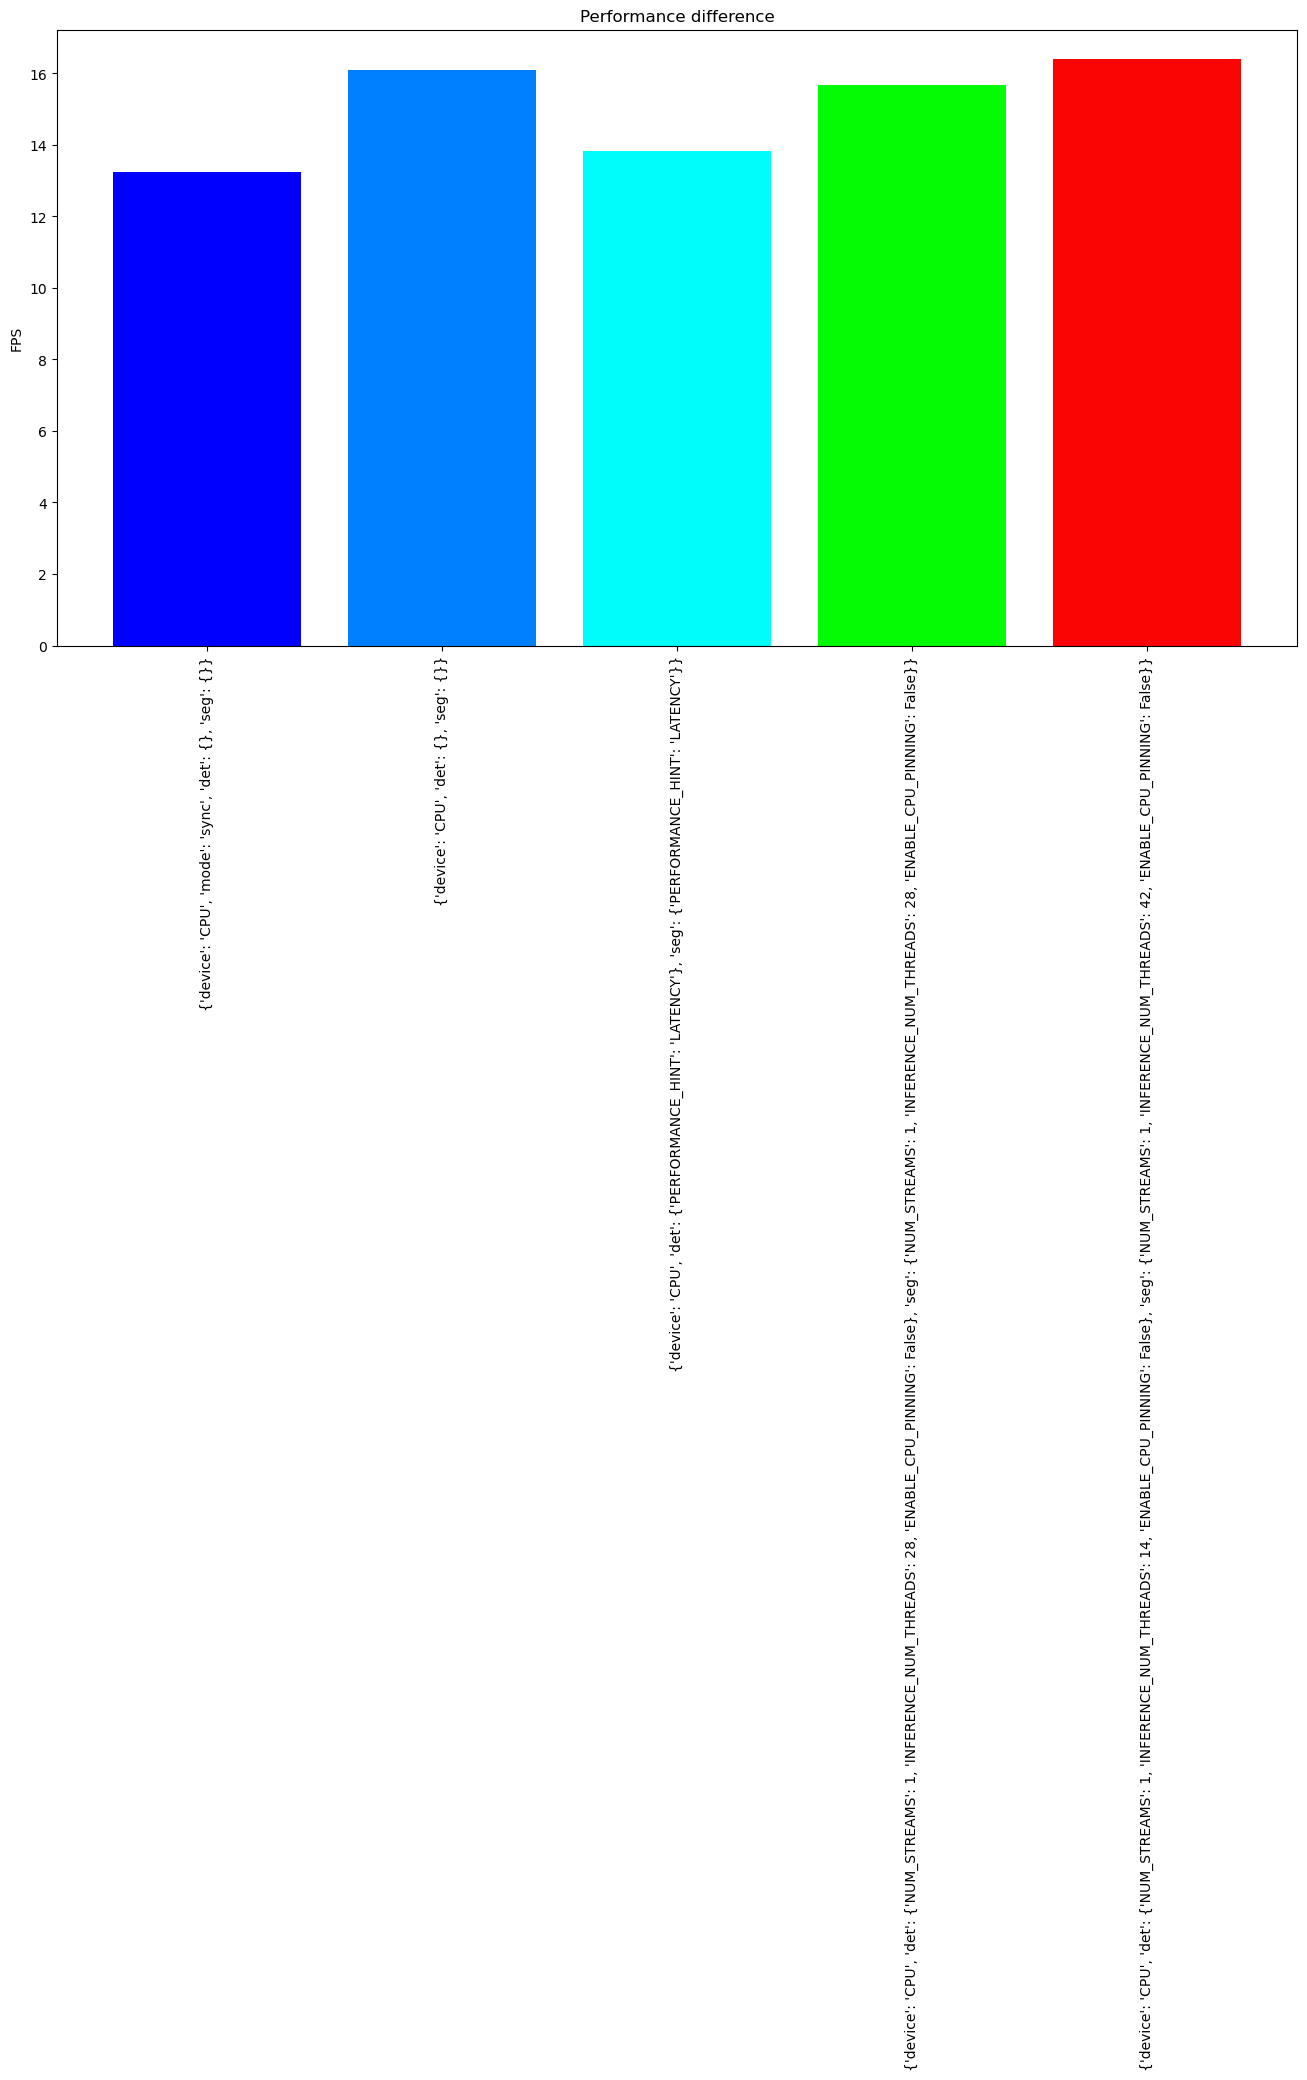

In [42]:
from matplotlib import pyplot as plt

bar_colors = cv2.applyColorMap(
    src=np.arange(0, 255, 255 / len(results), dtype=np.float32).astype(np.uint8),
    colormap=cv2.COLORMAP_RAINBOW,
).squeeze()

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(configs, results, color=bar_colors/ 255.0)

ax.set_ylabel("FPS")
ax.set_title("Performance difference")

plt.xticks(rotation='vertical')
plt.show()